# Tumour-Check Project

## Background

In the medicinal area and healthcare industry, various tools and instruments are being used to detect tumours. At initial stage of check-up, MRIs (Magnetic resonance imaging) are widely used by medicinal practitioners to confirm presence of tumours in a patient. Upon getting the result in form of MRI image and analysing the brain anatomy, doctors will be able to diagnose any tumours that are present in the patient's brain and start treatment or any medical procedures immediately.

In the recent years, healthcare sector in Singapore is suffering from manpower shortage in healthcare staffs. Additionally, demand for healthcare staffs and nurses are projected to continue to increase. The strain on manpower is further worsened by Singapore's declining fertility rate as well as growing aging population, both of which can aggravate further societal challenges in the long-run. These issues contributes to a bottleneck in the Singapore's supply of health workers and at the same time, potentially increasing demand for healthcare services. These pose as a major concern of future insufficient supply to meet the increasing demand. With the forementioned considerations, heathcare sector would need to find ways to reinvent operations in combating the manpower shortage and one of the potential ways would be tapping into automation and AI. 

These current issues led me to thinking, if tumours are diagnosed from analysing the photo of MRI scans to look for anomalies in the anatomy of the brain, will neural networks or machine learning models be able to learn and classify on presence of tumours? With this possibility in mind, AI and machine learning can be deployed in the field of medicine to increase the efficiency.

# Code

In [34]:
# Libaries/Packages
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import img_to_array

Numpy version: 1.24.2
TensorFlow version: 2.11.0


In [2]:
# loading the data set

file_tumour_no = 'brain_tumor_dataset/no/'
file_tumour_yes = 'brain_tumor_dataset/yes/'

jpg_tumour_no = os.listdir(file_tumour_no)
jpg_tumour_yes = os.listdir(file_tumour_yes)

length_tumour_no = len(os.listdir(file_tumour_no))
length_tumour_yes = len(os.listdir(file_tumour_yes))

print(length_tumour_no)
print(length_tumour_yes)

98
155


In [3]:
os.listdir(file_tumour_no)

['1 no.jpeg',
 '10 no.jpg',
 '11 no.jpg',
 '12 no.jpg',
 '13 no.jpg',
 '14 no.jpg',
 '15 no.jpg',
 '17 no.jpg',
 '18 no.jpg',
 '19 no.jpg',
 '2 no.jpeg',
 '20 no.jpg',
 '21 no.jpg',
 '22 no.jpg',
 '23 no.jpg',
 '24 no.jpg',
 '25 no.jpg',
 '26 no.jpg',
 '27 no.jpg',
 '28 no.jpg',
 '29 no.jpg',
 '3 no.jpg',
 '30 no.jpg',
 '31 no.jpg',
 '32 no.jpg',
 '33 no.jpg',
 '34 no.jpg',
 '35 no.jpg',
 '36 no.jpg',
 '37 no.jpg',
 '38 no.jpg',
 '39 no.jpg',
 '4 no.jpg',
 '40 no.jpg',
 '41 no.jpg',
 '42 no.jpg',
 '43 no.jpg',
 '44no.jpg',
 '45 no.jpg',
 '46 no.jpg',
 '47 no.jpg',
 '48 no.jpeg',
 '49 no.jpg',
 '5 no.jpg',
 '50 no.jpg',
 '6 no.jpg',
 '7 no.jpg',
 '8 no.jpg',
 '9 no.jpg',
 'N1.JPG',
 'N11.jpg',
 'N15.jpg',
 'N16.jpg',
 'N17.jpg',
 'N19.JPG',
 'N2.JPG',
 'N20.JPG',
 'N21.jpg',
 'N22.JPG',
 'N26.JPG',
 'N3.jpg',
 'N5.jpg',
 'N6.jpg',
 'no 1.jpg',
 'no 10.jpg',
 'no 100.jpg',
 'no 2.jpg',
 'no 3.jpg',
 'no 4.jpg',
 'no 5.jpeg',
 'no 6.jpg',
 'no 7.jpeg',
 'no 8.jpg',
 'no 89.jpg',
 'no 9.pn

In [4]:
def give_random_image(num, tumour):
    """Returns a list of specified number of random images based on tumour or non-tumour along with their label"""
    if not isinstance(tumour, bool):
        raise ValueError("Argument must contain a boolean value (True or False)")
    if tumour == True:
        length_tumour_yes = len(os.listdir(file_tumour_yes))
        sample_tumour_yes = np.random.choice(length_tumour_yes, size = num,replace = False)
        random_image = [img_to_array(load_img(file_tumour_yes + jpg_tumour_yes[i], target_size=(128, 128))) for i in sample_tumour_yes]
        labels = np.ones(num)
    else:
        length_tumour_no = len(os.listdir(file_tumour_no))
        sample_tumour_no = list(np.random.choice(length_tumour_no, size = num,replace = False))
        random_image = [img_to_array(load_img(file_tumour_no + jpg_tumour_no[i], target_size=(128, 128))) for i in sample_tumour_no]
        labels = np.zeros(num)
    random_image = np.array(random_image) / 255.0
        
    return random_image, labels

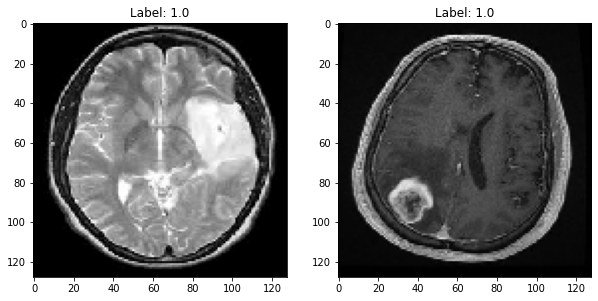

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (10,10))
tumours, label = give_random_image(2, tumour = True)

for i in range(2):
    axes[i].imshow(tumours[i])
    axes[i].set_title(f'Label: {label[i]}')

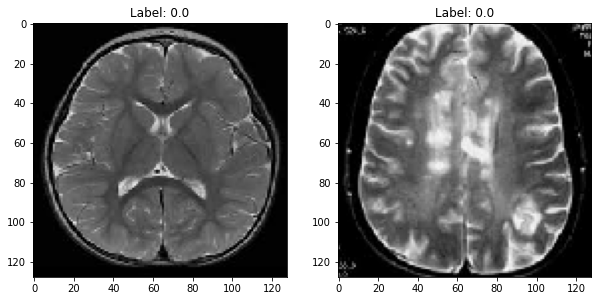

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (10,10))
tumours, label = give_random_image(2, tumour = False)

for i in range(2):
    axes[i].imshow(tumours[i])
    axes[i].set_title(f'Label: {label[i]}')

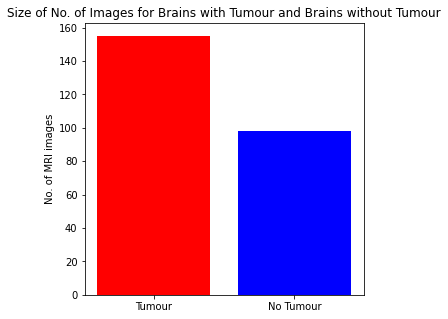

In [7]:
plt.figure(figsize=(5,5))
plt.bar(["Tumour", "No Tumour"], height=[length_tumour_yes, length_tumour_no], color = ['red','blue'])
plt.title('Size of No. of Images for Brains with Tumour and Brains without Tumour')
plt.ylabel('No. of MRI images')
plt.show()

## Preprocessing Data and Data Pipeline

In [8]:
# Data pipeline for MRI images

# tumour_data = np.array([mpimg.imread(file_tumour_yes + os.listdir(file_tumour_yes)[i]) for i in range(length_tumour_yes)])
# no_tumour_data = np.array([mpimg.imread(file_tumour_no + os.listdir(file_tumour_no)[i]) for i in range(length_tumour_no)])


In [9]:
# Create directories for training and test images
os.makedirs('processed_data/train/yes/', exist_ok = True)
os.makedirs('processed_data/train/no/', exist_ok = True)
os.makedirs('processed_data/test/yes/', exist_ok = True)
os.makedirs('processed_data/test/no/', exist_ok = True)

In [10]:
# Randomly shuffle the images
np.random.shuffle(jpg_tumour_yes)
np.random.shuffle(jpg_tumour_no)

#Splitting index
split_index_tumour = int(0.85*len(jpg_tumour_yes))
split_index_no_tumour = int(0.85*len(jpg_tumour_no))

print(split_index_tumour)
print(split_index_no_tumour)

131
83


In [11]:
#Split images to training and test sets at a 85-15 split.
tumour_train, tumour_test = jpg_tumour_yes[:split_index_tumour], jpg_tumour_yes[split_index_tumour:]
no_tumour_train, no_tumour_test = jpg_tumour_no[:split_index_no_tumour], jpg_tumour_no[split_index_no_tumour:]

print(len(tumour_train))
print(len(tumour_test))
print(len(no_tumour_train))
print(len(no_tumour_test))

131
24
83
15


In [12]:
# Quality check
# duplicates = []
# for i in tumour_train:
#     for n in tumour_test:
#         if i == n:
#             duplicate.append(i)
#             continue
# print(duplicates)

In [13]:
def remove_images(directory):
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [14]:
# Clear images in the train and test folders.
remove_images('processed_data/train/yes/')
remove_images('processed_data/train/no/')
remove_images('processed_data/test/yes/')
remove_images('processed_data/test/no/')


#Copy images over to training and testing folders.
for image in tumour_train:
    shutil.copy(file_tumour_yes + image,'processed_data/train/yes/' + image)
    
for image in tumour_test:
    shutil.copy(file_tumour_yes + image,'processed_data/test/yes/' + image)

for image in no_tumour_train:
    shutil.copy(file_tumour_no + image,'processed_data/train/no/' + image)
    
for image in no_tumour_test:
    shutil.copy(file_tumour_no + image,'processed_data/test/no/' + image)

In [15]:
def image_generator(validation_split=0.0):
    return ImageDataGenerator(rescale = (1/255.0),
                              rotation_range = 20,
                              fill_mode = "nearest",
                              validation_split = validation_split,
                              horizontal_flip = True,
                              vertical_flip = True,
                              brightness_range = [0.9, 1.1],
                              zoom_range=0.05)

In [16]:
#get objects of image generator for MRI images
mri_generator = image_generator(validation_split = 0.15)
test_mri_generator = image_generator()

In [17]:
mri_batch_size = 15

In [18]:
def get_generator(image_data_generator, directory, subset=None, seed = None):
    """Subset to indicate training or validation"""
    image_data_generator = image_data_generator.flow_from_directory(directory, target_size = (128,128),
                                                                    batch_size = mri_batch_size, class_mode = 'binary',
                                                                    shuffle = True, subset = subset ,
                                                                    seed = seed)
    
    return image_data_generator

In [19]:
train_mri_generator = get_generator(mri_generator, directory = 'processed_data/train/' , subset = 'training')
valid_mri_generator = get_generator(mri_generator, directory = 'processed_data/train/' , subset = 'validation')
test_mri_generator = get_generator(test_mri_generator, directory = 'processed_data/test/')

Found 183 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


(15, 128, 128, 3)
(15,)
[[[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]]

 [[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]]

 [[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]]

 ...

 [[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]]

 [[0.00392157 0.00392157 0.00392157]
  [0.00392157

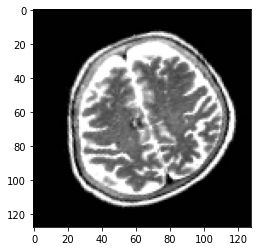

In [20]:
images, labels = next(train_mri_generator)
print(images.shape)
print(labels.shape)
print(images[0], labels[0])

plt.imshow(images[0])
plt.show()

In [21]:
#Reset train_mri_generator
train_mri_generator = get_generator(mri_generator, directory = 'processed_data/train/' , subset = 'training')


Found 183 images belonging to 2 classes.


## Modelling

In [22]:
def cnn_early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience = 5)

In [23]:
def cnn_best_checkpoint():
    best_checkpoint = 'mri_cnn_model/checkpoint'
    best_checkpoint = ModelCheckpoint(filepath = best_checkpoint,
                                      save_freq = 'epoch',
                                      monitor = 'val_binary_accuracy',
                                      save_best_only = True,
                                      verbose = 1)
    return best_checkpoint

In [24]:
def get_test_accuracy(model, test_generator):
    test_loss, test_acc, recall = model.evaluate(test_generator, verbose = 1)
    print('Test Loss: {loss:0.3f}\nTest Accuracy: {acc:0.3f}\nTest Recall: {recall:0.3f}'.format(loss = test_loss, acc = test_acc, recall=recall))

In [25]:
cnn_callbacks = [cnn_early_stopping(), cnn_best_checkpoint()]

In [26]:
def get_cnn_model(input_shape):
    model = Sequential([
        Conv2D(64, (3,3), strides = 1, activation = 'relu', padding = 'same', input_shape = input_shape, name = 'conv2d_1'),
        MaxPooling2D((2,2), name = 'maxpool2d_1', padding = 'same'),
        BatchNormalization(name = 'batchnorm_1'),
        Conv2D(128, (3,3), strides = 1, activation = 'relu', padding = 'same', input_shape = input_shape, name = 'conv2d_2'),
        MaxPooling2D((2,2), name = 'maxpool2d_2', padding = 'same'),
        Conv2D(128, (2,2), strides = 1, activation = 'relu', padding = 'same', input_shape = input_shape, name = 'conv2d_3'),
        MaxPooling2D((2,2), name = 'maxpool2d_3', padding = 'same'),
        Conv2D(256, (2,2), strides = 1, activation = 'relu', padding = 'same', input_shape = input_shape, name = 'conv2d_4'),
        MaxPooling2D((2,2), name = 'maxpool2d_4', padding = 'same'),
        Flatten(name = 'flatten_1'),
        Dense(256, activation = 'relu', name = 'dense_1'),
        Dense(128, activation = 'relu', name = 'dense_2'),
        Dense(1, activation = 'sigmoid', name = 'sigmoid_1')
    ])
    model.compile(tf.keras.optimizers.Adam(learning_rate = 0.00001), loss = 'binary_crossentropy', 
                  metrics = ['binary_accuracy', 'Recall'])
    return model


In [27]:
cnn_model = get_cnn_model((128,128,3))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 64, 64, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       65664     
                                                        

In [28]:
history = cnn_model.fit(train_mri_generator, validation_data = valid_mri_generator,
                        epochs = 30, steps_per_epoch=len(train_mri_generator), callbacks = cnn_callbacks)

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.6516 - binary_accuracy: 0.6230 - recall: 0.9196
Epoch 1: val_binary_accuracy improved from -inf to 0.61290, saving model to mri_cnn_model\checkpoint


INFO:tensorflow:Assets written to: mri_cnn_model\checkpoint\assets


INFO:tensorflow:Assets written to: mri_cnn_model\checkpoint\assets


13/13 [==============================] - 12s 787ms/step - loss: 0.6516 - binary_accuracy: 0.6230 - recall: 0.9196 - val_loss: 0.6678 - val_binary_accuracy: 0.6129 - val_recall: 1.0000
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.5806 - binary_accuracy: 0.6940 - recall: 0.9375
Epoch 2: val_binary_accuracy improved from 0.61290 to 0.70968, saving model to mri_cnn_model\checkpoint


INFO:tensorflow:Assets written to: mri_cnn_model\checkpoint\assets


INFO:tensorflow:Assets written to: mri_cnn_model\checkpoint\assets


13/13 [==============================] - 16s 1s/step - loss: 0.5806 - binary_accuracy: 0.6940 - recall: 0.9375 - val_loss: 0.6595 - val_binary_accuracy: 0.7097 - val_recall: 0.9474
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.5317 - binary_accuracy: 0.7705 - recall: 0.8839
Epoch 3: val_binary_accuracy improved from 0.70968 to 0.77419, saving model to mri_cnn_model\checkpoint


INFO:tensorflow:Assets written to: mri_cnn_model\checkpoint\assets


INFO:tensorflow:Assets written to: mri_cnn_model\checkpoint\assets


13/13 [==============================] - 12s 935ms/step - loss: 0.5317 - binary_accuracy: 0.7705 - recall: 0.8839 - val_loss: 0.6479 - val_binary_accuracy: 0.7742 - val_recall: 1.0000
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.5171 - binary_accuracy: 0.7705 - recall: 0.8304
Epoch 4: val_binary_accuracy improved from 0.77419 to 0.87097, saving model to mri_cnn_model\checkpoint


INFO:tensorflow:Assets written to: mri_cnn_model\checkpoint\assets


INFO:tensorflow:Assets written to: mri_cnn_model\checkpoint\assets


13/13 [==============================] - 10s 787ms/step - loss: 0.5171 - binary_accuracy: 0.7705 - recall: 0.8304 - val_loss: 0.6390 - val_binary_accuracy: 0.8710 - val_recall: 0.9474
Epoch 5/30
13/13 [==============================] - ETA: 0s - loss: 0.5062 - binary_accuracy: 0.7760 - recall: 0.8750
Epoch 5: val_binary_accuracy did not improve from 0.87097
13/13 [==============================] - 8s 628ms/step - loss: 0.5062 - binary_accuracy: 0.7760 - recall: 0.8750 - val_loss: 0.6334 - val_binary_accuracy: 0.7742 - val_recall: 0.8947
Epoch 6/30
13/13 [==============================] - ETA: 0s - loss: 0.4846 - binary_accuracy: 0.7869 - recall: 0.8839
Epoch 6: val_binary_accuracy did not improve from 0.87097
13/13 [==============================] - 7s 538ms/step - loss: 0.4846 - binary_accuracy: 0.7869 - recall: 0.8839 - val_loss: 0.6274 - val_binary_accuracy: 0.8387 - val_recall: 0.8947
Epoch 7/30
13/13 [==============================] - ETA: 0s - loss: 0.4841 - binary_accuracy: 0.77

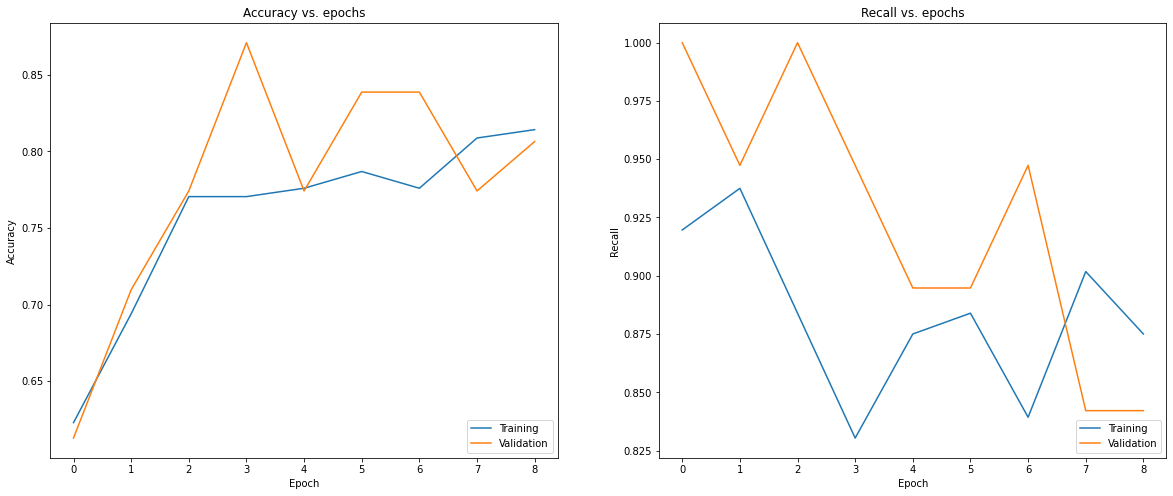

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (20,8))

axes[0].plot(history.history['binary_accuracy'])
axes[0].plot(history.history['val_binary_accuracy'])

axes[0].set_title('Accuracy vs. epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history.history['recall'])
axes[1].plot(history.history['val_recall'])
axes[1].set_title('Recall vs. epochs')
axes[1].set_ylabel('Recall')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='lower right')
plt.show()


## Testing Model

In [30]:
get_test_accuracy(cnn_model, test_mri_generator)

3/3 [==============================] - 1s 204ms/step - loss: 0.6505 - binary_accuracy: 0.8205 - recall: 1.0000
Test Loss: 0.651
Test Accuracy: 0.821
Test Recall: 1.000


1/1 [==============================] - 0s 39ms/step


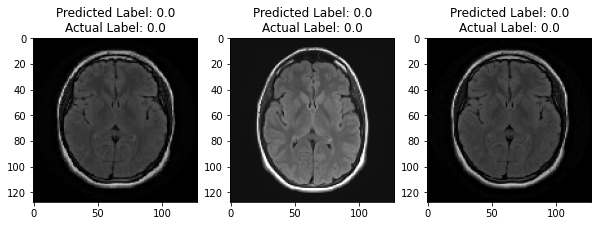

In [37]:
fig, axes = plt.subplots(1, 3, figsize = (10,10))
tumours_1, label_1 = give_random_image(3, tumour = False)
predicted_labels_1 = [1.0 if cnn_model.predict(tumour.reshape((1,) + tumour.shape))[0][0] > 0.5 else 0.0 for tumour in tumours_1]

for i in range(3):
    axes[i].imshow(tumours_1[i])
    axes[i].set_title(f'Predicted Label: {predicted_labels_1[i]}\nActual Label: {label_1[i]}')

1/1 [==============================] - 0s 44ms/step


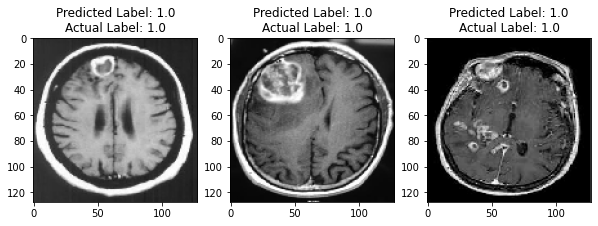

In [38]:
fig, axes = plt.subplots(1, 3, figsize = (10,10))
tumours_2, label_2 = give_random_image(3, tumour = True)
predicted_labels_2 = [1.0 if cnn_model.predict(tumour.reshape((1,) + tumour.shape))[0][0] > 0.5 else 0.0 for tumour in tumours_2]

for i in range(3):
    axes[i].imshow(tumours_2[i])
    axes[i].set_title(f'Predicted Label: {predicted_labels_2[i]}\nActual Label: {label_2[i]}')

# References

1. https://www.businesstimes.com.sg/singapore/economy-policy/24000-more-nurses-healthcare-staff-needed-2030-spore-ages